This notebook is intended to produce the vizualisations of Figure 3 from the paper. 

It deals with regularized optimal transport for Monge-Kantorovich quantiles in dimension `d=2`.

It studies the change-of-variable in polar coordinates that enables to reparametrize our FFT, and consider as a reference law the spherical uniform.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import ot
sns.set()

### Generate the data 

[0.00455961 0.331949  ]


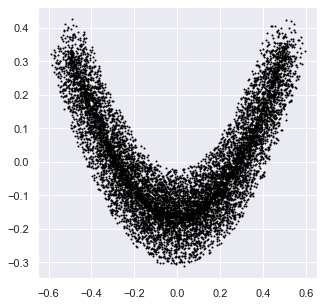

In [3]:
J = 10**4

######################
# Banana shaped data 
######################

d = 2 
X = -1 + 2 * np.random.random_sample((J,))
Phi = 2 * np.pi * np.random.random_sample((J,))
Z = np.random.random_sample((J,))
R = 0.2 * Z * (1+(1-abs(X))/2)
y1 = X + R * np.cos(Phi)
y2 = X**2 + R * np.sin(Phi)
Y = np.array([y1,y2])
Y = Y.T

# Center-reduce is necessary for computational reasons in EOT
scale = 2
print(np.mean(Y,axis=0))
Y = (Y-np.mean(Y,axis=0))/scale

plt.figure(figsize=(5,5))
plt.scatter(Y.T[0],Y.T[1],color="black",s=1)

### Grid from the spherical uniform distribution

The choice of the following parameters p1 and p2 can be changed in order to obtain the two distinct columns of figure 2.

In [13]:
# Choice of the grid with polar coordinates
p1 = 20 # number of radius
p2 = 500 # number of angles

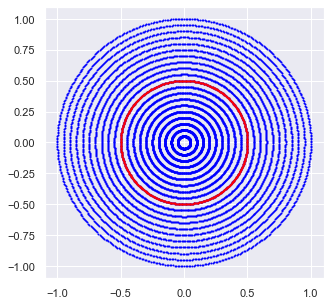

In [5]:
grid_r = np.mgrid[1:(p1+1), 1:(p2+1)][0]/p1
grid_theta = (np.mgrid[1:(p1+1), 1:(p2+1)][1]/p2)*2*np.pi

# Vizualise points in cartesian coordinates
grid_x1 = grid_r*np.cos(grid_theta)
grid_x2 = grid_r*np.sin(grid_theta)
grid_x = np.array([grid_x1,grid_x2])

plt.figure(figsize=(5,5))
plt.scatter(grid_x1[:].reshape(p1*p2,1),grid_x2[:].reshape(p1*p2,1),color="blue",s=1)

# Vizualise a circle, i.e. the antecedent from the quantile map of a quantile contour.
k = int(p1/2-1)
plt.scatter(grid_x1[k,:].reshape(p2,1),grid_x2[k,:].reshape(p2,1),color="red",s=1)

### Define the functions

In [6]:
def cost_fft2(grid_x,Y):
    diff1 = grid_x[0]-Y[0]
    diff2 = grid_x[1]-Y[1]
    return(0.5*(diff1**2 + diff2**2))

# Version FFT
def c_transform_fft2(u, grid_x, y, eps=0.1):
    """Calculate the c_transform of u"""
    arg = (u - cost_fft2(grid_x, y))/eps
    to_sum = np.exp(arg)
    return(-eps*np.log(np.mean(to_sum)))
    
def grad_heps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the gradient h_eps 
    """

    F_u = np.exp((u - cost_fft2(grid_x, y))/eps)
    argD = np.mean(F_u)
    grad = -np.fft.fft2(F_u)/argD

    return(grad)

def h_eps_fft2(u, grid_x, y, eps=0.1):
    """
    Calculate the function h_eps whose expectation equals H_eps.
    """
    return(c_transform_fft2(u, grid_x, y, eps)-eps)

def Robbins_Monro_Algo_fft2(grid_x, Y, u, eps=0.1, gamma= 1, c = 3/4, alpha= 0, epoch = 1):   
    n = Y.shape[0]
    n_iter = n*epoch
    
    # Tirage des Y le long des itérations
    if (epoch == 1):
        sample = np.arange(n)
    else:
        sample = np.random.choice(a=np.arange(n), size=n_iter)
    
    # Choix de la matrice de poids W pour l'algorithme basé sur la FFT
    p1 = grid_x[0].shape[0]
    p2 = grid_x[0].shape[1]
    freqs = np.meshgrid(np.fft.fftfreq(p1),np.fft.fftfreq(p2))
    freqs[0][0,0] = 1/p1
    freqs[1][0,0] = 1/p2
    # W = 1/(np.sqrt((p1*freqs[0])**2+(p2*freqs[1])**2)**alpha).T
    W = 1/((p2*freqs[1])**alpha).T
    
    # Stockage des estimateurs recursifs.
    W_hat_storage = np.zeros(n_iter)
    h_eps_storage = np.zeros(n_iter)

    # Initialisation du vecteur u
    fft_u = np.fft.fft2(u)
    
    # Premiere iteration pour lancer la boucle.
    y_0 = Y[sample[0],:] 
    W_hat_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)
    h_eps_storage[0] = h_eps_fft2(u, grid_x, y_0, eps)

    # Boucle de Robbins Monro.
    for k in range(1,n_iter):

        # Tirage d'une réalisation selon la loi mu.
        y = Y[sample[k],:]
        
        # Mise à jour de la valeur de fft_u et mise à zéro de son intégrale
        u = np.real(np.fft.ifft2(fft_u))
        fft_u = fft_u + gamma/((k+1)**c) * W * grad_heps_fft2(u, grid_x, y, eps)
        fft_u[0,0] = 0
        
        # Stockage de la valeur de h_eps 
        h_eps_storage[k] = h_eps_fft2(u, grid_x, y, eps)
        
        # Evaluation de l'approximation de la divergence de Sinkhorn.
        W_hat_storage[k] = k/(k+1) * W_hat_storage[k-1] + 1/(k+1) * h_eps_storage[k]
        
        # Stockage de la valeur de u à chaque itération
        u = u-np.mean(u)
        
    L = [u, W_hat_storage]
    
    return(L)

### Solving optimal transport with our FFT-based scheme  

In [7]:
eps = 0.005
# Learning rate depending on epsilon
gamma = eps

# Choix du nombre d'epoch
epoch = 100
n = Y.shape[0] 

n_iter = n*epoch

# Initialisation
u0 = np.zeros([p1,p2])    

# Compute the regularized maps by RM-FTT
res_RM_fft = Robbins_Monro_Algo_fft2(grid_x, Y, u=u0, eps=eps, gamma = gamma, c = 3/4, alpha = 0, epoch = epoch)
hat_u = res_RM_fft[0]
hat_W = res_RM_fft[1]

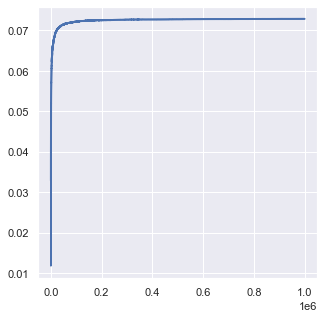

In [8]:
plt.figure(figsize=(5,5))
plt.plot(np.arange(n_iter),hat_W)
n_start=100
plt.plot(np.arange(n_start,n_iter),hat_W[n_start:],'b',linewidth=2)

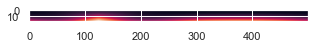

In [9]:
# Dual potential with polar coordinates
plt.figure(figsize=(5,5))
plt.imshow(hat_u)

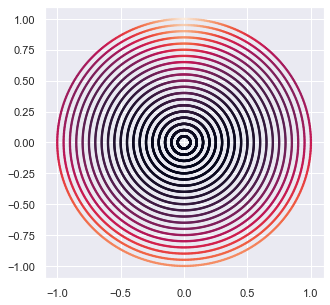

In [10]:
# Dual potential with cartesian coordinates
plt.figure(figsize=(5,5))
p = grid_x[0].shape[0]
plt.scatter(grid_x1[:].reshape(p1*p2,1),grid_x2[:].reshape(p1*p2,1),c=hat_u.reshape(p1*p2,1),s=2)
plt.savefig('Figures/fig2_discrete_u_polar_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.png',bbox_inches='tight')

In [11]:
# Calculus of the gradient of u by finite differences in polar coordinates
diff_hat_u = np.gradient(hat_u)
diff_grad_hat_u = np.array([diff_hat_u[0]*p1,-diff_hat_u[1]*p2/(2*np.pi)])

# Change of variable,
# Rotation of the gradient in polar coordinates towards the cartesian coordinates
A1 = np.array([np.cos(grid_theta),(1/grid_r)*np.sin(grid_theta)])
A2 = np.array([np.sin(grid_theta),(-1/grid_r)*np.cos(grid_theta)])

rot_diff_grad_hat_u1 = diff_grad_hat_u[0]*A1[0]+diff_grad_hat_u[1]*A1[1]
rot_diff_grad_hat_u2 = diff_grad_hat_u[0]*A2[0]+diff_grad_hat_u[1]*A2[1]
rot_diff_grad_hat_u = np.array([rot_diff_grad_hat_u1,rot_diff_grad_hat_u2])

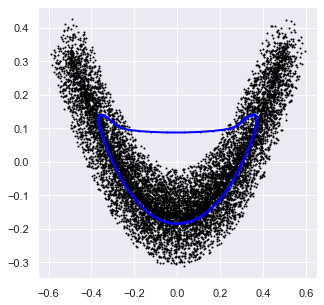

In [12]:
# Optimal transport mapping in cartesian coordinates
hat_T1 = grid_x[0] - rot_diff_grad_hat_u[0]
hat_T2 = grid_x[1] - rot_diff_grad_hat_u[1]
hat_T = np.array([hat_T1,hat_T2])

# Visualisation of a quantile contour
plt.figure(figsize=(5,5))
plt.scatter(Y.T[0],Y.T[1],color="black",s=1)

k = int(p1/2-1)
plt.plot(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color="blue",linewidth=2)
plt.scatter(hat_T1[k,:].reshape(p2,1),hat_T2[k,:].reshape(p2,1),color="blue",s=1)

plt.savefig('Figures/fig2_discrete_contour50_fft_p1_'+str(int(p1))+'_p2_'+str(int(p2))+'_epsilon_'+str(eps)+'_J_'+str(int(J))+'_n_iter_'+str(int(n_iter))+'.eps',bbox_inches='tight')